In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import gc
import time
from pandas.core.common import SettingWithCopyWarning
import warnings
import lightgbm as lgb
from sklearn.model_selection import GroupKFold
from IPython.display import display

# I don't like SettingWithCopyWarnings ...
warnings.simplefilter('error', SettingWithCopyWarning)
gc.enable()
%matplotlib inline

In [2]:
train = pd.read_csv('../input/create-extracted-json-fields-dataset/extracted_fields_train.gz', 
                    dtype={'date': str, 'fullVisitorId': str, 'sessionId':str}, nrows=None)
test = pd.read_csv('../input/create-extracted-json-fields-dataset/extracted_fields_test.gz', 
                   dtype={'date': str, 'fullVisitorId': str, 'sessionId':str}, nrows=None)
train.shape, test.shape

((903653, 30), (804684, 30))

In [3]:
temp = list(train[train.loc[:,'totals.transactionRevenue']>0].loc[:,'totals.transactionRevenue'])
v = np.mean(temp)+np.std(temp)*2

In [4]:
def get_folds(df=None, n_splits=5):
    """Returns dataframe indices corresponding to Visitors Group KFold"""
    # Get sorted unique visitors
    unique_vis = np.array(sorted(df['fullVisitorId'].unique()))

    # Get folds
    folds = GroupKFold(n_splits=n_splits)
    fold_ids = []
    ids = np.arange(df.shape[0])
    for trn_vis, val_vis in folds.split(X=unique_vis, y=unique_vis, groups=unique_vis):
        fold_ids.append(
            [
                ids[df['fullVisitorId'].isin(unique_vis[trn_vis])],
                ids[df['fullVisitorId'].isin(unique_vis[val_vis])]
            ]
        )

    return fold_ids

train['totals.transactionRevenue'] = train['totals.transactionRevenue'].fillna(0)
train = train[train.loc[:,'totals.transactionRevenue']<v]
y_reg = train['totals.transactionRevenue']
del train['totals.transactionRevenue']

if 'totals.transactionRevenue' in test.columns:
    del test['totals.transactionRevenue']
    
train['target'] = y_reg
for df in [train, test]:
    df['vis_date'] = pd.to_datetime(df['visitStartTime'], unit='s')
    df['sess_date_dow'] = df['vis_date'].dt.dayofweek
    df['sess_date_hours'] = df['vis_date'].dt.hour
    df['sess_date_dom'] = df['vis_date'].dt.day
    df.sort_values(['fullVisitorId', 'vis_date'], ascending=True, inplace=True)
    df['next_session_1'] = (
        df['vis_date'] - df[['fullVisitorId', 'vis_date']].groupby('fullVisitorId')['vis_date'].shift(1)
    ).astype(np.int64) // 1e9 // 60 // 60
    df['next_session_2'] = (
        df['vis_date'] - df[['fullVisitorId', 'vis_date']].groupby('fullVisitorId')['vis_date'].shift(-1)
    ).astype(np.int64) // 1e9 // 60 // 60
    
#     df['max_visits'] = df['fullVisitorId'].map(
#         df[['fullVisitorId', 'visitNumber']].groupby('fullVisitorId')['visitNumber'].max()
#     )
    
    df['nb_pageviews'] = df['date'].map(
        df[['date', 'totals.pageviews']].groupby('date')['totals.pageviews'].sum()
    )
    
    df['ratio_pageviews'] = df['totals.pageviews'] / df['nb_pageviews']
    
#     df['nb_sessions'] = df['date'].map(
#         df[['date']].groupby('date').size()
#     )
    
#     df['nb_sessions_28_ma'] = df['date'].map(
#         df[['date']].groupby('date').size().rolling(28, min_periods=7).mean()
#     )

#     df['nb_sessions_28_ma'] = df['nb_sessions'] / df['nb_sessions_28_ma']

#     df['nb_sessions_per_day'] = df['date'].map(
#         df[['date']].groupby('date').size()
#     )
    
#     df['nb_visitors_per_day'] = df['date'].map(
#         df[['date','fullVisitorId']].groupby('date')['fullVisitorId'].nunique()
#     )

y_reg = train['target']
del train['target']

In [79]:
excluded_features = [
    'date', 'fullVisitorId', 'sessionId', 'totals.transactionRevenue', 
    'visitId', 'visitStartTime', 'vis_date', 'nb_sessions', 'max_visits'
]

categorical_features = [
    _f for _f in train.columns
    #if (_f not in excluded_features) & (train[_f].dtype == 'object') & (_f != 'geoNetwork.networkDomain') # geoNetwork.networkDomainは多すぎ
    if (_f != 'geoNetwork.networkDomain') # geoNetwork.networkDomainは多すぎ
]

#for f in categorical_features:
#    train[f], indexer = pd.factorize(train[f])
#    test[f] = indexer.get_indexer(test[f])


study_data = pd.concat([train,test], axis=0)
train_row_n = len(train)


temp = pd.get_dummies(study_data[categorical_features], sparse=True)

"""
temp_mat = temp.to_coo()

def train_test_divide(mat):
    #return mat[:train_row_n,:],mat[train_row_n:,:]
    mat = sparse.csr_matrix(mat)
    return mat[:train_row_n,:],mat[train_row_n:,:]

train_sparse,test_sparse = train_test_divide(temp_mat)


train_sparse = pd.SparseDataFrame(train_sparse)
test_sparse = pd.SparseDataFrame(test_sparse)
train_sparse.columns = temp.columns
test_sparse.columns = temp.columns
"""
train_sparse = temp.iloc[0:train_row_n,:]
test_sparse = temp.iloc[train_row_n:len(temp),:]


print(train_sparse.shape)
print(train_sparse.columns)

(903470, 3041989)
Index(['visitId', 'visitNumber', 'visitStartTime', 'device.isMobile',
       'totals.bounces', 'totals.hits', 'totals.newVisits', 'totals.pageviews',
       'trafficSource.isTrueDirect', 'vis_date',
       ...
       'trafficSource.source_wikihow.com',
       'trafficSource.source_wunderbin.corp.google.com',
       'trafficSource.source_x20web.corp.google.com',
       'trafficSource.source_xbidprodmirror.corp.google.com',
       'trafficSource.source_yahoo', 'trafficSource.source_yahoo.com',
       'trafficSource.source_yandex', 'trafficSource.source_youtube.com',
       'trafficSource.source_youtube.thinkwithgoogle.com',
       'trafficSource.source_yt-go-12345.googleplex.com'],
      dtype='object', length=3041989)


In [11]:
# 基礎分析
for col in categorical_features:
    temp = len(train.groupby([col]).size())
    print(col, temp)

channelGrouping 8
device.browser 54
device.deviceCategory 3
device.operatingSystem 20
geoNetwork.city 649
geoNetwork.continent 6
geoNetwork.country 222
geoNetwork.metro 94
geoNetwork.networkDomain 28064
geoNetwork.region 376
geoNetwork.subContinent 23
trafficSource.adContent 44
trafficSource.campaign 10
trafficSource.keyword 3658
trafficSource.medium 7
trafficSource.referralPath 1475
trafficSource.source 380


In [27]:
#pass

from scipy import sparse
from copy import deepcopy

study_data = pd.concat([train,test], axis=0)
train_row_n = len(train)

def train_test_divide(mat):
    #return mat[:train_row_n,:],mat[train_row_n:,:]
    mat = sparse.csr_matrix(mat)
    return mat[:train_row_n,:],mat[train_row_n:,:]

def return_sparse_mat(df, columns):
    study_row_n = len(study_data)
    # スパース行列の設定
    row_n = study_row_n
    #col_n = len(df.groupby([columns]).size())
    col_n = len(df.iloc[:train_row_n,:].groupby([columns]).size())
    my_result = sparse.lil_matrix((row_n,col_n))

    # 非ゼロ要素の格納
    #convert_map = df.groupby([columns], as_index = False).size()
    convert_map = df.iloc[:train_row_n,:].groupby([columns], as_index = False).size()
    convert_map = pd.DataFrame({columns:convert_map.index,'n':range(len(convert_map))})
    convert_dict = {convert_map.loc[key,columns]:key for key in convert_map.index}
    column_value_list = list(df.loc[:,columns])
    for i in range(my_result.shape[0]):
        try:
            my_result[i, convert_dict[column_value_list[i]]] = 1
        except:
            pass
    #print('create sparse-mat:', columns)
    return my_result


for i,col in enumerate(study_data.columns):
    if (col == 'geoNetwork.networkDomain') or (col in excluded_features):
        continue

    if col not in categorical_features:
        _sparse = sparse.lil_matrix(study_data[col])
        _sparse = _sparse.T
        train_sparse,test_sparse = train_test_divide(_sparse)
    elif col in categorical_features:
        print(col)
        _sparse = return_sparse_mat(study_data, col)
        train_sparse,test_sparse = train_test_divide(_sparse)
    
    if i == 0:
        train_out = deepcopy(train_sparse)
        test_out = deepcopy(test_sparse)
    else:
        train_out = sparse.hstack([train_out,train_sparse])
        test_out = sparse.hstack([test_out,test_sparse])

channelGrouping
date
--> pass
fullVisitorId
--> pass
sessionId
--> pass
visitId
--> pass
visitNumber
visitStartTime
--> pass
device.browser
device.deviceCategory
device.isMobile
device.operatingSystem
geoNetwork.city
geoNetwork.continent
geoNetwork.country
geoNetwork.metro
geoNetwork.networkDomain
--> pass
geoNetwork.region
geoNetwork.subContinent
totals.bounces
totals.hits
totals.newVisits
totals.pageviews
trafficSource.adContent
trafficSource.campaign
trafficSource.isTrueDirect
trafficSource.keyword
trafficSource.medium
trafficSource.referralPath
trafficSource.source
vis_date
--> pass
sess_date_dow
sess_date_hours
sess_date_dom
next_session_1
next_session_2
nb_pageviews
ratio_pageviews


In [5]:
# https://www.kaggle.com/prashantkikani/teach-lightgbm-to-sum-predictions-fe
def browser_mapping(x):
    browsers = ['chrome','safari','firefox','internet explorer','edge','opera','coc coc','maxthon','iron']
    if x in browsers:
        return x.lower()
    elif  ('android' in x) or ('samsung' in x) or ('mini' in x) or ('iphone' in x) or ('in-app' in x) or ('playstation' in x):
        return 'mobile browser'
    elif  ('mozilla' in x) or ('chrome' in x) or ('blackberry' in x) or ('nokia' in x) or ('browser' in x) or ('amazon' in x):
        return 'mobile browser'
    elif  ('lunascape' in x) or ('netscape' in x) or ('blackberry' in x) or ('konqueror' in x) or ('puffin' in x) or ('amazon' in x):
        return 'mobile browser'
    elif '(not set)' in x:
        return x
    else:
        return 'others'
    
    
def adcontents_mapping(x):
    if  ('google' in x):
        return 'google'
    elif  ('placement' in x) | ('placememnt' in x):
        return 'placement'
    elif '(not set)' in x or 'nan' in x:
        return x
    elif 'ad' in x:
        return 'ad'
    else:
        return 'others'
    
def source_mapping(x):
    if  ('google' in x):
        return 'google'
    elif  ('youtube' in x):
        return 'youtube'
    elif '(not set)' in x or 'nan' in x:
        return x
    elif 'yahoo' in x:
        return 'yahoo'
    elif 'facebook' in x:
        return 'facebook'
    elif 'reddit' in x:
        return 'reddit'
    elif 'bing' in x:
        return 'bing'
    elif 'quora' in x:
        return 'quora'
    elif 'outlook' in x:
        return 'outlook'
    elif 'linkedin' in x:
        return 'linkedin'
    elif 'pinterest' in x:
        return 'pinterest'
    elif 'ask' in x:
        return 'ask'
    elif 'siliconvalley' in x:
        return 'siliconvalley'
    elif 'lunametrics' in x:
        return 'lunametrics'
    elif 'amazon' in x:
        return 'amazon'
    elif 'mysearch' in x:
        return 'mysearch'
    elif 'qiita' in x:
        return 'qiita'
    elif 'messenger' in x:
        return 'messenger'
    elif 'twitter' in x:
        return 'twitter'
    elif 't.co' in x:
        return 't.co'
    elif 'vk.com' in x:
        return 'vk.com'
    elif 'search' in x:
        return 'search'
    elif 'edu' in x:
        return 'edu'
    elif 'mail' in x:
        return 'mail'
    elif 'ad' in x:
        return 'ad'
    elif 'golang' in x:
        return 'golang'
    elif 'direct' in x:
        return 'direct'
    elif 'dealspotr' in x:
        return 'dealspotr'
    elif 'sashihara' in x:
        return 'sashihara'
    elif 'phandroid' in x:
        return 'phandroid'
    elif 'baidu' in x:
        return 'baidu'
    elif 'mdn' in x:
        return 'mdn'
    elif 'duckduckgo' in x:
        return 'duckduckgo'
    elif 'seroundtable' in x:
        return 'seroundtable'
    elif 'metrics' in x:
        return 'metrics'
    elif 'sogou' in x:
        return 'sogou'
    elif 'businessinsider' in x:
        return 'businessinsider'
    elif 'github' in x:
        return 'github'
    elif 'gophergala' in x:
        return 'gophergala'
    elif 'yandex' in x:
        return 'yandex'
    elif 'msn' in x:
        return 'msn'
    elif 'dfa' in x:
        return 'dfa'
    elif '(not set)' in x:
        return '(not set)'
    elif 'feedly' in x:
        return 'feedly'
    elif 'arstechnica' in x:
        return 'arstechnica'
    elif 'squishable' in x:
        return 'squishable'
    elif 'flipboard' in x:
        return 'flipboard'
    elif 't-online.de' in x:
        return 't-online.de'
    elif 'sm.cn' in x:
        return 'sm.cn'
    elif 'wow' in x:
        return 'wow'
    elif 'baidu' in x:
        return 'baidu'
    elif 'partners' in x:
        return 'partners'
    else:
        return 'others'

train['device.browser'] = train['device.browser'].map(lambda x:browser_mapping(str(x).lower())).astype('str')
train['trafficSource.adContent'] = train['trafficSource.adContent'].map(lambda x:adcontents_mapping(str(x).lower())).astype('str')
train['trafficSource.source'] = train['trafficSource.source'].map(lambda x:source_mapping(str(x).lower())).astype('str')

test['device.browser'] = test['device.browser'].map(lambda x:browser_mapping(str(x).lower())).astype('str')
test['trafficSource.adContent'] = test['trafficSource.adContent'].map(lambda x:adcontents_mapping(str(x).lower())).astype('str')
test['trafficSource.source'] = test['trafficSource.source'].map(lambda x:source_mapping(str(x).lower())).astype('str')

def process_device(data_df):
    print("process device ...")
    data_df['source.country'] = data_df['trafficSource.source'] + '_' + data_df['geoNetwork.country']
    data_df['campaign.medium'] = data_df['trafficSource.campaign'] + '_' + data_df['trafficSource.medium']
    data_df['browser.category'] = data_df['device.browser'] + '_' + data_df['device.deviceCategory']
    data_df['browser.os'] = data_df['device.browser'] + '_' + data_df['device.operatingSystem']
    return data_df

train = process_device(train)
test = process_device(test)

def custom(data):
    print('custom..')
    data['device_deviceCategory_channelGrouping'] = data['device.deviceCategory'] + "_" + data['channelGrouping']
    data['channelGrouping_browser'] = data['device.browser'] + "_" + data['channelGrouping']
    data['channelGrouping_OS'] = data['device.operatingSystem'] + "_" + data['channelGrouping']
    
    for i in ['geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country','geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region','geoNetwork.subContinent']:
        for j in ['device.browser','device.deviceCategory', 'device.operatingSystem', 'trafficSource.source']:
            data[i + "_" + j] = data[i] + "_" + data[j]
    
    data['content.source'] = data['trafficSource.adContent'] + "_" + data['source.country']
    data['medium.source'] = data['trafficSource.medium'] + "_" + data['source.country']
    return data

train = custom(train)
test = custom(test)

excluded_features = [
    'date', 'fullVisitorId', 'sessionId', 'totals.transactionRevenue', 
    'visitId', 'visitStartTime', 'vis_date', 'nb_sessions', 'max_visits'
]

categorical_features = [
    _f for _f in train.columns
    if (_f not in excluded_features) & (train[_f].dtype == 'object')
]

for f in categorical_features:
    train[f], indexer = pd.factorize(train[f])
    test[f] = indexer.get_indexer(test[f])

process device ...
process device ...
custom..
custom..


In [7]:
#train = train_sparse
#test = test_sparse

folds = get_folds(df=train, n_splits=5)

train_features = [_f for _f in train.columns if (_f not in excluded_features) and (_f != 'geoNetwork.networkDomain')]
print(train_features)

importances = pd.DataFrame()
oof_reg_preds = np.zeros(train.shape[0])
sub_reg_preds = np.zeros(test.shape[0])
for fold_, (trn_, val_) in enumerate(folds):
    trn_x, trn_y = train[train_features].iloc[trn_], y_reg.iloc[trn_]
    val_x, val_y = train[train_features].iloc[val_], y_reg.iloc[val_]
    
    reg = lgb.LGBMRegressor(
        num_leaves=31,
        learning_rate=0.03,
        n_estimators=1000,
        subsample=.9,
        colsample_bytree=.9,
        random_state=1
    )
    reg.fit(
        trn_x, np.log1p(trn_y),
        eval_set=[(val_x, np.log1p(val_y))],
        early_stopping_rounds=50,
        verbose=100,
        eval_metric='rmse'
    )
    imp_df = pd.DataFrame()
    imp_df['feature'] = train_features
    imp_df['gain'] = reg.booster_.feature_importance(importance_type='gain')
    
    imp_df['fold'] = fold_ + 1
    importances = pd.concat([importances, imp_df], axis=0, sort=False)
    
    oof_reg_preds[val_] = reg.predict(val_x, num_iteration=reg.best_iteration_)
    oof_reg_preds[oof_reg_preds < 0] = 0
    _preds = reg.predict(test[train_features], num_iteration=reg.best_iteration_)
    _preds[_preds < 0] = 0
    sub_reg_preds += np.expm1(_preds) / len(folds)
    
mean_squared_error(np.log1p(y_reg), oof_reg_preds) ** .5

['channelGrouping', 'visitNumber', 'device.browser', 'device.deviceCategory', 'device.isMobile', 'device.operatingSystem', 'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country', 'geoNetwork.metro', 'geoNetwork.region', 'geoNetwork.subContinent', 'totals.bounces', 'totals.hits', 'totals.newVisits', 'totals.pageviews', 'trafficSource.adContent', 'trafficSource.campaign', 'trafficSource.isTrueDirect', 'trafficSource.keyword', 'trafficSource.medium', 'trafficSource.referralPath', 'trafficSource.source', 'sess_date_dow', 'sess_date_hours', 'sess_date_dom', 'next_session_1', 'next_session_2', 'nb_pageviews', 'ratio_pageviews', 'source.country', 'campaign.medium', 'browser.category', 'browser.os', 'device_deviceCategory_channelGrouping', 'channelGrouping_browser', 'channelGrouping_OS', 'geoNetwork.city_device.browser', 'geoNetwork.city_device.deviceCategory', 'geoNetwork.city_device.operatingSystem', 'geoNetwork.city_trafficSource.source', 'geoNetwork.continent_device.browser', 'geo

1.5843846914732513

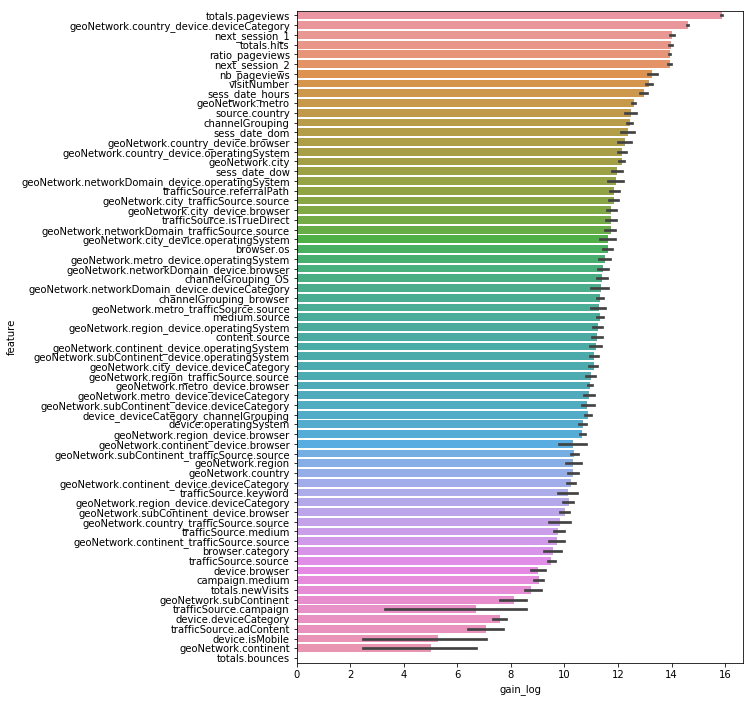

In [8]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

importances['gain_log'] = np.log1p(importances['gain'])
mean_gain = importances[['gain', 'feature']].groupby('feature').mean()
importances['mean_gain'] = importances['feature'].map(mean_gain['gain'])

plt.figure(figsize=(8, 12))
sns.barplot(x='gain_log', y='feature', data=importances.sort_values('mean_gain', ascending=False))

In [9]:
train['predictions'] = np.expm1(oof_reg_preds)
test['predictions'] = sub_reg_preds

# Aggregate data at User level
trn_data = train[train_features + ['fullVisitorId']].groupby('fullVisitorId').mean()

In [10]:
%%time
# Create a list of predictions for each Visitor
trn_pred_list = train[['fullVisitorId', 'predictions']].groupby('fullVisitorId')\
    .apply(lambda df: list(df.predictions))\
    .apply(lambda x: {'pred_'+str(i): pred for i, pred in enumerate(x)})

CPU times: user 40.6 s, sys: 355 ms, total: 41 s
Wall time: 41.6 s


In [11]:
# Create a DataFrame with VisitorId as index
# trn_pred_list contains dict 
# so creating a dataframe from it will expand dict values into columns
trn_all_predictions = pd.DataFrame(list(trn_pred_list.values), index=trn_data.index)
trn_feats = trn_all_predictions.columns
trn_all_predictions['t_mean'] = np.log1p(trn_all_predictions[trn_feats].mean(axis=1))
trn_all_predictions['t_median'] = np.log1p(trn_all_predictions[trn_feats].median(axis=1))
trn_all_predictions['t_sum_log'] = np.log1p(trn_all_predictions[trn_feats]).sum(axis=1)
trn_all_predictions['t_sum_act'] = np.log1p(trn_all_predictions[trn_feats].fillna(0).sum(axis=1))
trn_all_predictions['t_nb_sess'] = trn_all_predictions[trn_feats].isnull().sum(axis=1)
full_data = pd.concat([trn_data, trn_all_predictions], axis=1)
del trn_data, trn_all_predictions
gc.collect()
full_data.shape

/Users/daiyamita/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log1p
  


(714153, 339)

In [12]:
%%time
sub_pred_list = test[['fullVisitorId', 'predictions']].groupby('fullVisitorId')\
    .apply(lambda df: list(df.predictions))\
    .apply(lambda x: {'pred_'+str(i): pred for i, pred in enumerate(x)})

CPU times: user 36.3 s, sys: 459 ms, total: 36.7 s
Wall time: 38.2 s


In [13]:
sub_data = test[train_features + ['fullVisitorId']].groupby('fullVisitorId').mean()
sub_all_predictions = pd.DataFrame(list(sub_pred_list.values), index=sub_data.index)
for f in trn_feats:
    if f not in sub_all_predictions.columns:
        sub_all_predictions[f] = np.nan
sub_all_predictions['t_mean'] = np.log1p(sub_all_predictions[trn_feats].mean(axis=1))
sub_all_predictions['t_median'] = np.log1p(sub_all_predictions[trn_feats].median(axis=1))
sub_all_predictions['t_sum_log'] = np.log1p(sub_all_predictions[trn_feats]).sum(axis=1)
sub_all_predictions['t_sum_act'] = np.log1p(sub_all_predictions[trn_feats].fillna(0).sum(axis=1))
sub_all_predictions['t_nb_sess'] = sub_all_predictions[trn_feats].isnull().sum(axis=1)
sub_full_data = pd.concat([sub_data, sub_all_predictions], axis=1)
del sub_data, sub_all_predictions
gc.collect()
sub_full_data.shape

train['target'] = y_reg
trn_user_target = train[['fullVisitorId', 'target']].groupby('fullVisitorId').sum()

/Users/daiyamita/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log1p
  


In [14]:
folds = get_folds(df=full_data[['totals.pageviews']].reset_index(), n_splits=5)

oof_preds = np.zeros(full_data.shape[0])
sub_preds = np.zeros(sub_full_data.shape[0])
vis_importances = pd.DataFrame()

for fold_, (trn_, val_) in enumerate(folds):
    trn_x, trn_y = full_data.iloc[trn_], trn_user_target['target'].iloc[trn_]
    val_x, val_y = full_data.iloc[val_], trn_user_target['target'].iloc[val_]
    
    reg = lgb.LGBMRegressor(
        num_leaves=31,
        learning_rate=0.03,
        n_estimators=1000,
        subsample=.9,
        colsample_bytree=.9,
        random_state=1
    )
    reg.fit(
        trn_x, np.log1p(trn_y),
        eval_set=[(trn_x, np.log1p(trn_y)), (val_x, np.log1p(val_y))],
        eval_names=['TRAIN', 'VALID'],
        early_stopping_rounds=50,
        eval_metric='rmse',
        verbose=100
    )
    
    imp_df = pd.DataFrame()
    imp_df['feature'] = trn_x.columns
    imp_df['gain'] = reg.booster_.feature_importance(importance_type='gain')
    
    imp_df['fold'] = fold_ + 1
    vis_importances = pd.concat([vis_importances, imp_df], axis=0, sort=False)
    
    oof_preds[val_] = reg.predict(val_x, num_iteration=reg.best_iteration_)
    oof_preds[oof_preds < 0] = 0
    
    # Make sure features are in the same order
    _preds = reg.predict(sub_full_data[full_data.columns], num_iteration=reg.best_iteration_)
    _preds[_preds < 0] = 0
    sub_preds += _preds / len(folds)
    
mean_squared_error(np.log1p(trn_user_target['target']), oof_preds) ** .5

Training until validation scores don't improve for 50 rounds.
[100]	TRAIN's rmse: 1.51686	VALID's rmse: 1.59137
Early stopping, best iteration is:
[139]	TRAIN's rmse: 1.49636	VALID's rmse: 1.5887
Training until validation scores don't improve for 50 rounds.
[100]	TRAIN's rmse: 1.52843	VALID's rmse: 1.5459
Early stopping, best iteration is:
[147]	TRAIN's rmse: 1.50432	VALID's rmse: 1.54372
Training until validation scores don't improve for 50 rounds.
[100]	TRAIN's rmse: 1.51853	VALID's rmse: 1.58177
Early stopping, best iteration is:
[113]	TRAIN's rmse: 1.51135	VALID's rmse: 1.58091
Training until validation scores don't improve for 50 rounds.
[100]	TRAIN's rmse: 1.52094	VALID's rmse: 1.57188
[200]	TRAIN's rmse: 1.47939	VALID's rmse: 1.56746
Early stopping, best iteration is:
[169]	TRAIN's rmse: 1.4892	VALID's rmse: 1.56684
Training until validation scores don't improve for 50 rounds.
[100]	TRAIN's rmse: 1.5193	VALID's rmse: 1.57703
Early stopping, best iteration is:
[140]	TRAIN's rmse:

1.5711853477020068

In [18]:
from xgboost import XGBRegressor

xgb_params = {
        'objective': 'reg:linear',
        'booster': 'gbtree',
        'learning_rate': 0.02,
        'max_depth': 22,
        'min_child_weight': 57,
        'gamma' : 1.45,
        'alpha': 0.0,
        'lambda': 0.0,
        'subsample': 0.67,
        'colsample_bytree': 0.054,
        'colsample_bylevel': 0.50,
        'n_jobs': -1,
        'random_state': 456
    }

folds = get_folds(df=full_data[['totals.pageviews']].reset_index(), n_splits=5)

oof_preds = np.zeros(full_data.shape[0])
oof_preds1 = np.zeros(full_data.shape[0])
both_oof = np.zeros(full_data.shape[0])
sub_preds = np.zeros(sub_full_data.shape[0])
vis_importances = pd.DataFrame()

for fold_, (trn_, val_) in enumerate(folds):
    print("-"* 20 + "Fold :"+str(fold_) + "-"* 20)
    trn_x, trn_y = full_data.iloc[trn_], trn_user_target['target'].iloc[trn_]
    val_x, val_y = full_data.iloc[val_], trn_user_target['target'].iloc[val_]
    xg = XGBRegressor(**xgb_params, n_estimators=1000)
    reg = lgb.LGBMRegressor(
        num_leaves=31,
        learning_rate=0.03,
        n_estimators=1000,
        subsample=.9,
        colsample_bytree=.9,
        random_state=1
    )
    print("-"* 20 + "LightGBM Training" + "-"* 20)
    reg.fit(
        trn_x, np.log1p(trn_y),
        eval_set=[(trn_x, np.log1p(trn_y)), (val_x, np.log1p(val_y))],
        eval_names=['TRAIN', 'VALID'],
        early_stopping_rounds=50,
        eval_metric='rmse',
        verbose=100
    )
    print("-"* 20 + "Xgboost Training" + "-"* 20)
    xg.fit(
        trn_x, np.log1p(trn_y),
        eval_set=[(trn_x, np.log1p(trn_y)), (val_x, np.log1p(val_y))],
        early_stopping_rounds=50,
        eval_metric='rmse',
        verbose=100
    )
    imp_df = pd.DataFrame()
    imp_df['feature'] = trn_x.columns
    imp_df['gain'] = reg.booster_.feature_importance(importance_type='gain')

    imp_df['fold'] = fold_ + 1
    vis_importances = pd.concat([vis_importances, imp_df], axis=0, sort=False)

    oof_preds[val_] = reg.predict(val_x, num_iteration=reg.best_iteration_)
    oof_preds1[val_] = xg.predict(val_x)

    oof_preds[oof_preds < 0] = 0
    oof_preds1[oof_preds1 < 0] = 0

    both_oof[val_] = oof_preds[val_] * 0.6 + oof_preds1[val_] * 0.4

    # Make sure features are in the same order
    _preds = reg.predict(sub_full_data[full_data.columns], num_iteration=reg.best_iteration_)
    _preds[_preds < 0] = 0

    pre = xg.predict(sub_full_data[full_data.columns])
    pre[pre<0]=0

    sub_preds += (_preds / len(folds)) * 0.6 + (pre / len(folds)) * 0.4
    
print("LGB  ", mean_squared_error(np.log1p(trn_user_target['target']), oof_preds) ** .5)
print("XGB  ", mean_squared_error(np.log1p(trn_user_target['target']), oof_preds1) ** .5)
print("Combine  ", mean_squared_error(np.log1p(trn_user_target['target']), both_oof) ** .5)

--------------------Fold :0--------------------
--------------------LightGBM Training--------------------
Training until validation scores don't improve for 50 rounds.
[100]	TRAIN's rmse: 1.51686	VALID's rmse: 1.59137
Early stopping, best iteration is:
[139]	TRAIN's rmse: 1.49636	VALID's rmse: 1.5887
--------------------Xgboost Training--------------------
[0]	validation_0-rmse:2.08817	validation_1-rmse:2.1105
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[100]	validation_0-rmse:1.72475	validation_1-rmse:1.76454
[200]	validation_0-rmse:1.59941	validation_1-rmse:1.65692
[300]	validation_0-rmse:1.54557	validation_1-rmse:1.61841
[400]	validation_0-rmse:1.51482	validation_1-rmse:1.6031
[500]	validation_0-rmse:1.49263	validation_1-rmse:1.59633
[600]	validation_0-rmse:1.47344	validation_1-rmse:1.59265
[700]	validation_0-rmse:1.45837	validation_1-rmse:1.59116
[800]	validation_0-rms

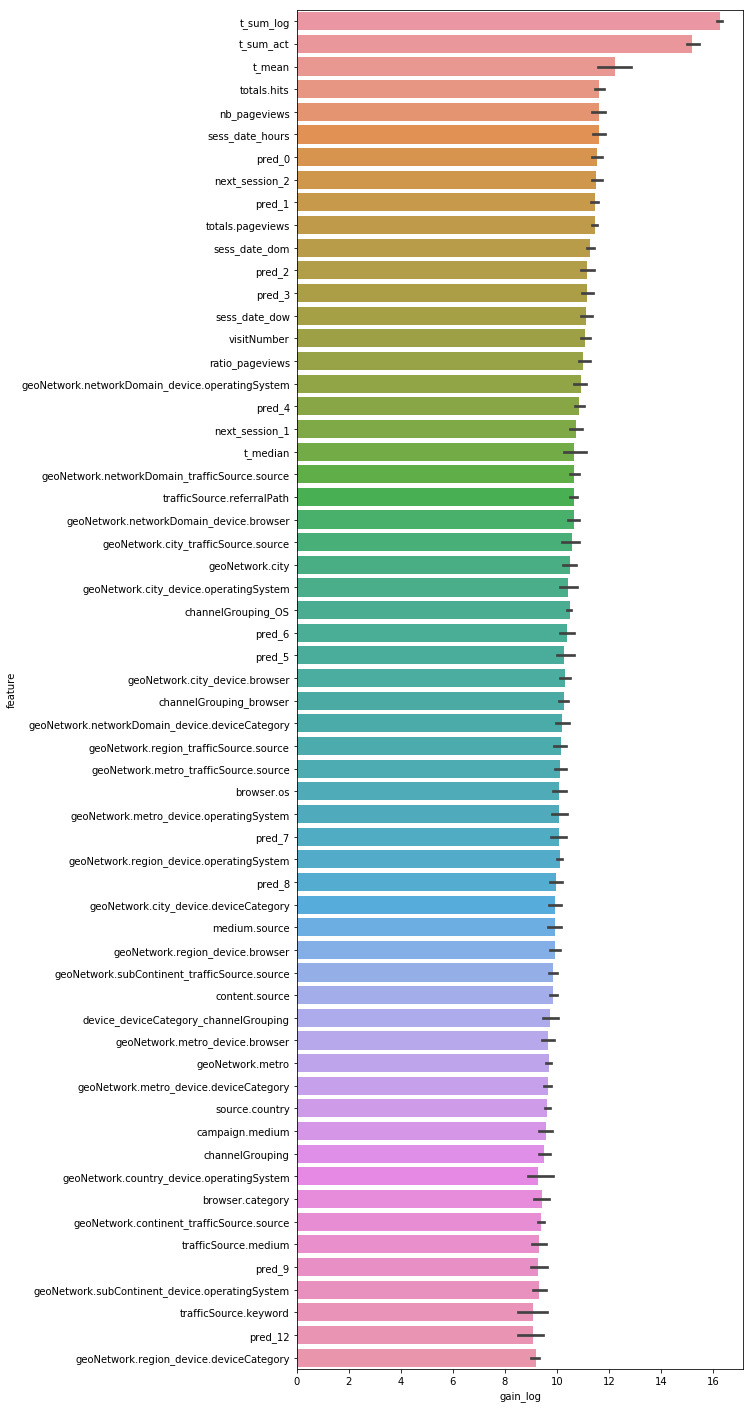

In [19]:
vis_importances['gain_log'] = np.log1p(vis_importances['gain'])
mean_gain = vis_importances[['gain', 'feature']].groupby('feature').mean()
vis_importances['mean_gain'] = vis_importances['feature'].map(mean_gain['gain'])

plt.figure(figsize=(8, 25))
sns.barplot(x='gain_log', y='feature', data=vis_importances.sort_values('mean_gain', ascending=False).iloc[:300])

In [20]:
sub_full_data['PredictedLogRevenue'] = sub_preds
sub_full_data[['PredictedLogRevenue']].to_csv('new_test_5.csv', index=True)